In [117]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import datetime as dt
from datetime import timedelta
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso, Lars
from sklearn.model_selection import train_test_split
import seaborn as sns

In [118]:
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AAPL&apikey=PO92AAFJTA0YPQBR'
r = requests.get(url)
data = r.json()

time_series_data = data['Time Series (Daily)']

# Convert to DataFrame
df = pd.DataFrame(time_series_data).T

# Reset index and rename columns
df.reset_index(inplace=True)
df.rename(columns={'index': 'timestamp'}, inplace=True)

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Convert string values to float
for col in df.columns[1:]:
    df[col] = df[col].astype(float)

df = df.sort_values(by = ['timestamp'])
df

,timestamp,1. open,2. high,3. low,4. close,5. volume
99,2024-02-02,179.860,187.330,179.2500,185.85,102551680.0
98,2024-02-05,188.150,189.250,185.8400,187.68,69668820.0
97,2024-02-06,186.860,189.310,186.7695,189.30,43490759.0
96,2024-02-07,190.640,191.050,188.6100,189.41,53438955.0
95,2024-02-08,189.385,189.535,187.3500,188.32,40962046.0
...,...,...,...,...,...,...
4,2024-06-20,213.930,214.240,208.8500,209.68,86172451.0
3,2024-06-21,210.390,211.890,207.1100,207.49,246421353.0
2,2024-06-24,207.720,212.700,206.5900,208.14,80727006.0
1,2024-06-25,209.150,211.380,208.6100,209.07,56713868.0


In [119]:
df.dtypes

timestamp    datetime64[ns]
1. open             float64
2. high             float64
3. low              float64
4. close            float64
5. volume           float64
dtype: object

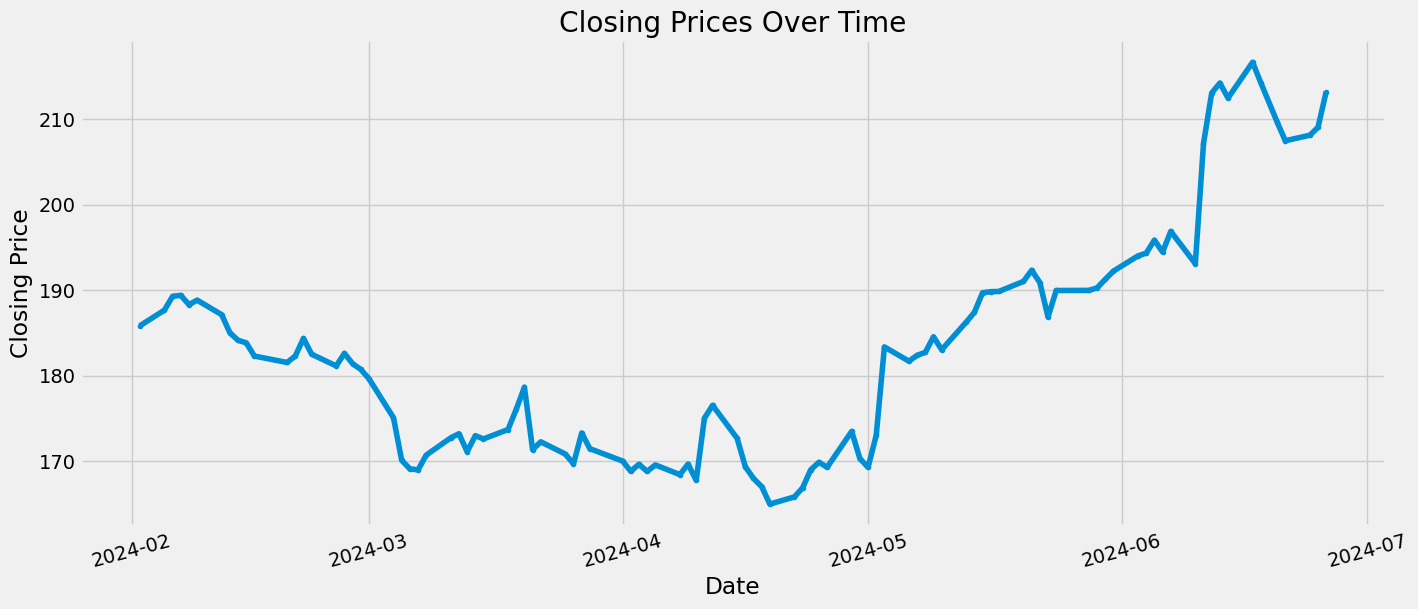

In [120]:
#basic graph of the given company's stock prices
plt.style.use('fivethirtyeight')


plt.figure(figsize=(15, 6))
plt.plot(df['timestamp'], df['4. close'], marker = '.')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=15)
plt.grid(True)
plt.show()

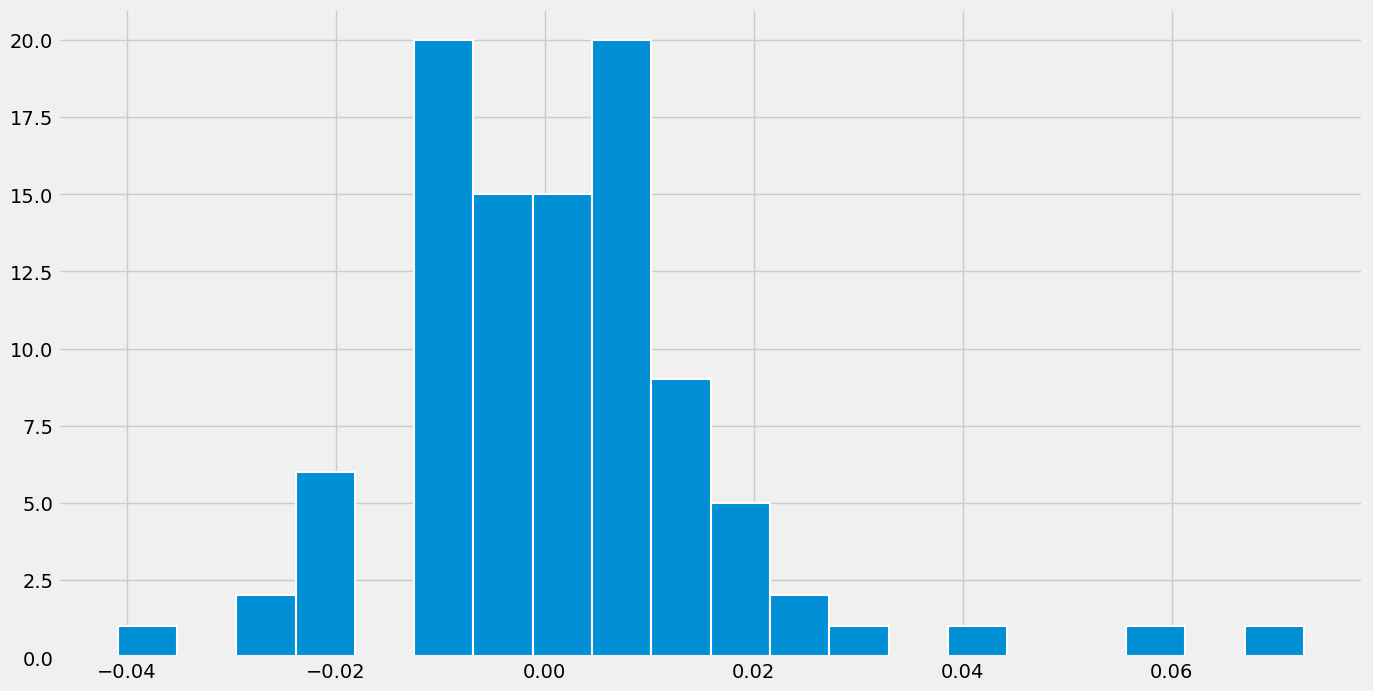

In [121]:
df['9. daily change'] = df['4. close'].pct_change()

plt.figure(figsize = (15, 8))
plt.hist(df['9. daily change'], bins = 20, linewidth = 1.5, edgecolor = 'white')
plt.grid(True)
plt.show()

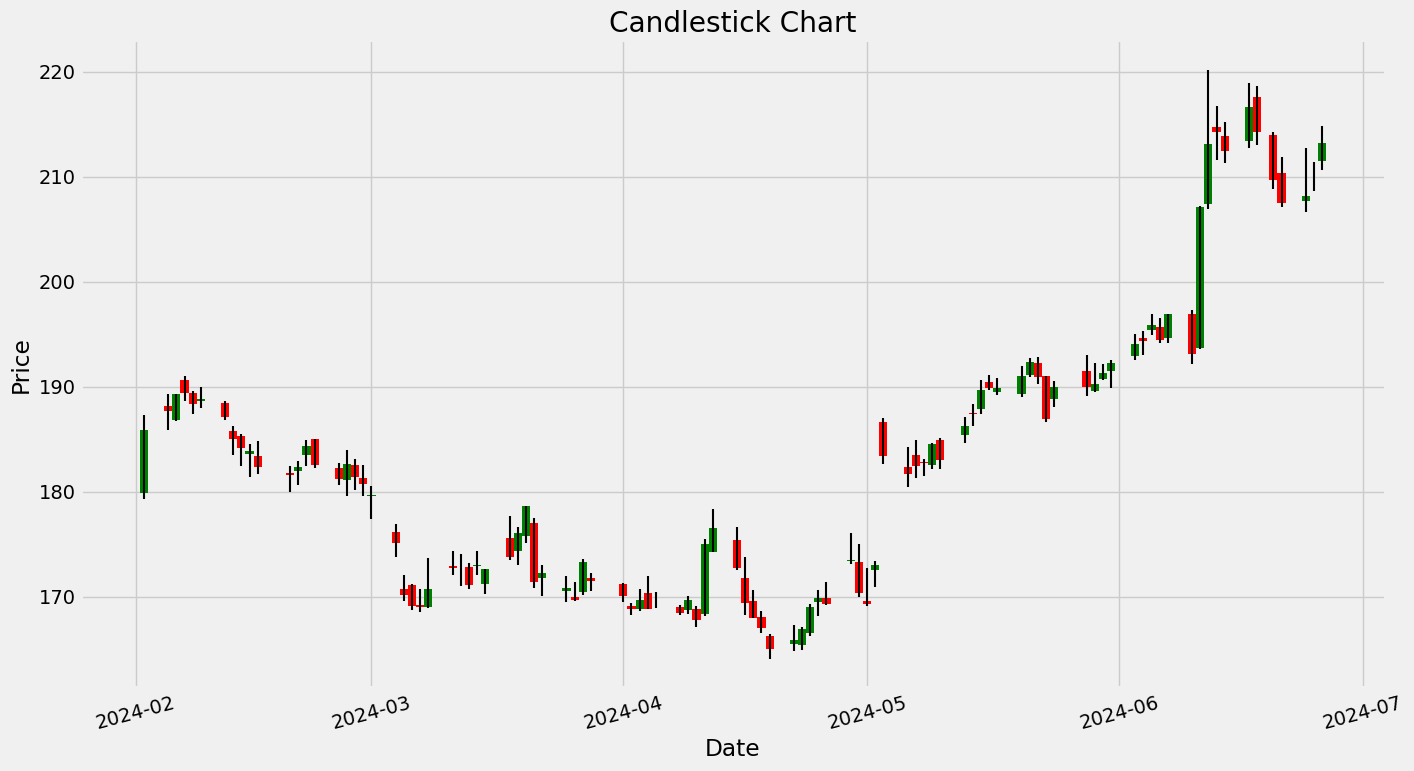

In [122]:
#candle plot of the given comapny's stock prices
green_df = df[df['4. close'] > df['1. open']].copy()
green_df['Height'] = green_df['4. close'] - green_df['1. open']

red_df = df[df['4. close'] < df['1. open']].copy()
red_df['Height'] = red_df['4. close'] - red_df['1. open']

plt.figure(figsize=(15, 8))
plt.vlines(x = df['timestamp'], ymin = df['3. low'], ymax = df['2. high'], color = 'black', linewidth = 1.5)
#green ones
plt.bar(x = green_df['timestamp'], height = green_df['Height'], bottom = green_df['1. open'], color = 'green', width = 1)

#red ones
plt.bar(x = red_df['timestamp'], height = red_df['Height'], bottom = red_df['1. open'], color = 'red', width = 1)

plt.title('Candlestick Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=15)
plt.grid(True)

plt.show()


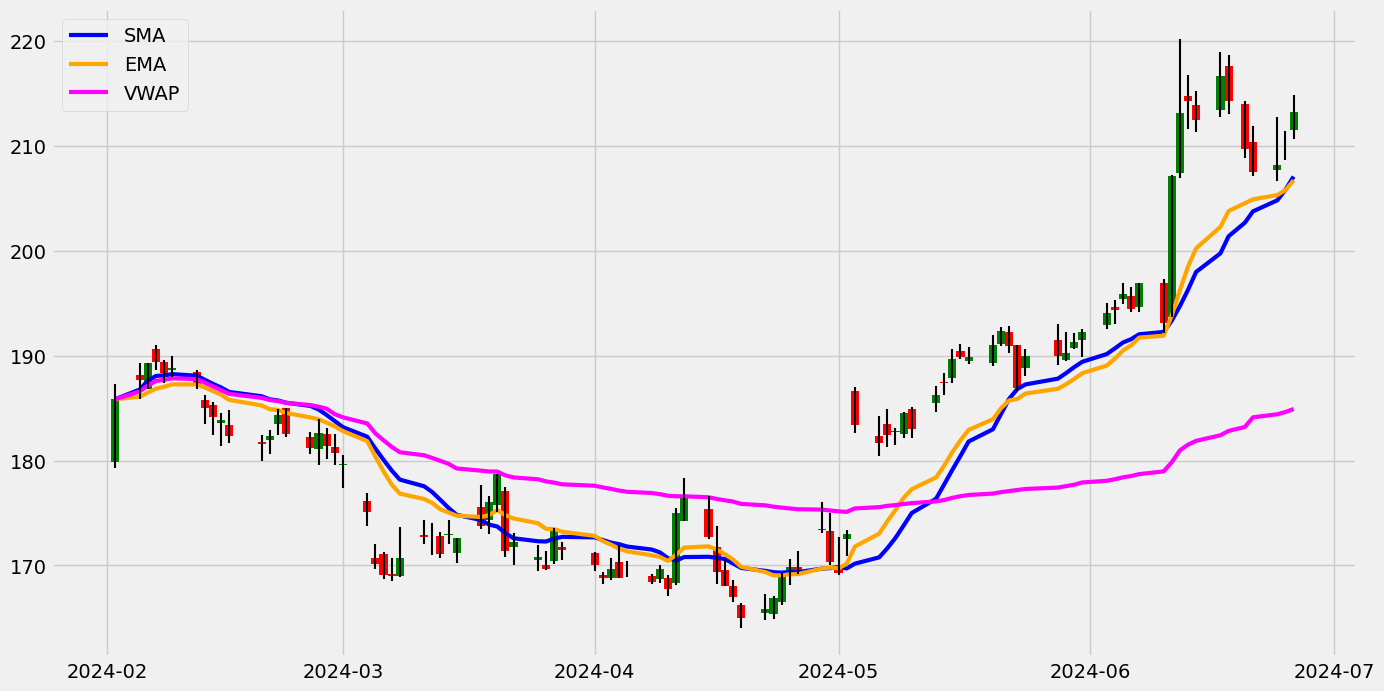

In [123]:
#simple moving averages
#exponential moving averages
#volume-weighted average price
size = 15

df['6. sma'] = df['4. close'].rolling(window = size, min_periods = 1).mean()
    
df['7. ema'] = df['4. close'].ewm(span = size, adjust = False).mean()
    
df['8. vwap'] = (df['5. volume'] * df['4. close']).cumsum() / df['5. volume'].cumsum()
    

plt.figure(figsize = (15, 8))
plt.plot(df['timestamp'], df['6. sma'], '-', linewidth = 3, color = 'blue', label = 'SMA')
plt.plot(df['timestamp'], df['7. ema'], '-', linewidth = 3, color = 'orange', label = 'EMA')
plt.plot(df['timestamp'], df['8. vwap'], '-', linewidth = 3, color = 'fuchsia', label = 'VWAP')
plt.vlines(x = df['timestamp'], ymin = df['3. low'], ymax = df['2. high'], color = 'black', linewidth = 1.5)
plt.bar(x = green_df['timestamp'], height = green_df['Height'], bottom = green_df['1. open'], color = 'green', width = 1)
plt.bar(x = red_df['timestamp'], height = red_df['Height'], bottom = red_df['1. open'], color = 'red', width = 1)
plt.grid(True)
plt.legend()
plt.show()


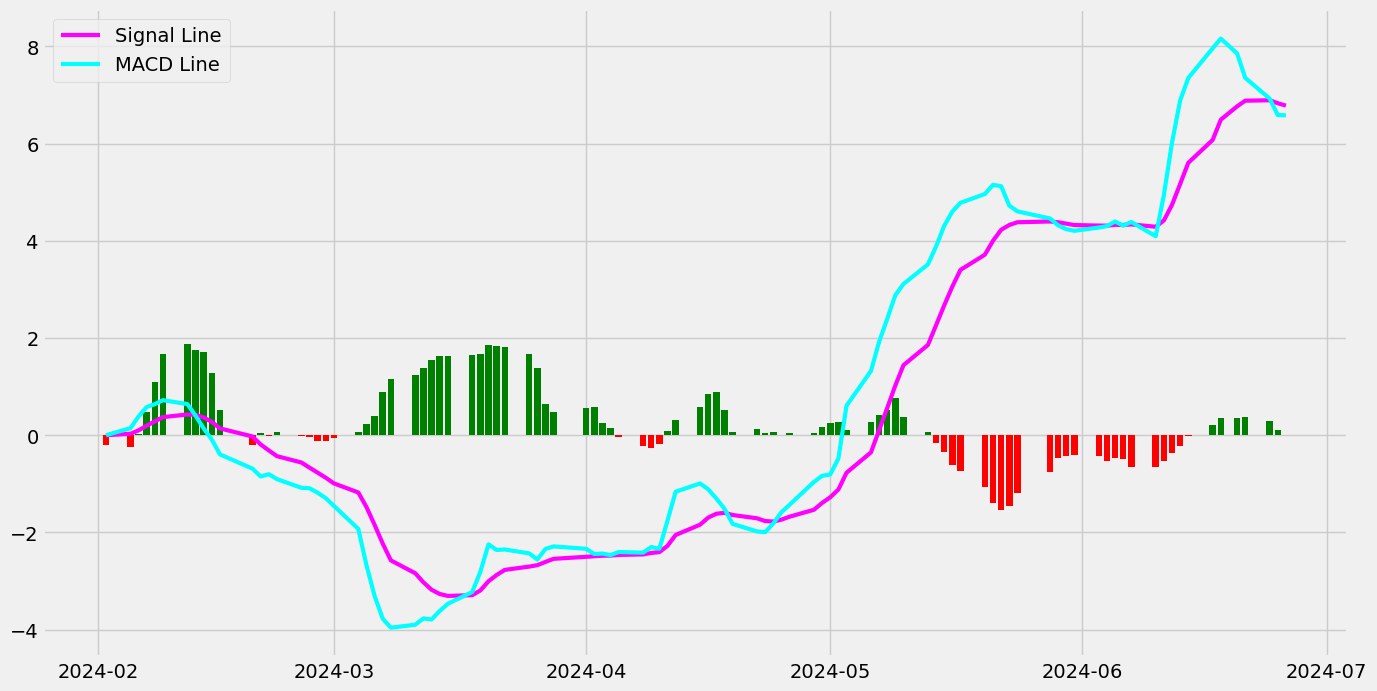

In [124]:
#MACD Line = 12-day EMA – 26-day EMA
#Signal Line = 9-day EMA of the MACD Line
#Histogram = MACD Line – Signal Line

short_period = 12
long_period = 26
signal_period = 9

short_ema = df['4. close'].ewm(span = short_period, adjust = False).mean()
    
long_ema = df['4. close'].ewm(span = long_period, adjust = False).mean()

macd_line = short_ema - long_ema
    
signal_line = macd_line.ewm(span = signal_period, adjust = False).mean()

    
macd_hist = [macd_line[i] - signal_line[i] for i in range(len(macd_line))]

macd_hist_green = [i if i > 0 else 0 for i in macd_hist]
macd_hist_red = [i if i < 0 else 0 for i in macd_hist]
    
plt.figure(figsize = (15, 8))
plt.plot(df['timestamp'], signal_line, '-', linewidth = 3, color = 'magenta', label = 'Signal Line')
plt.plot(df['timestamp'], macd_line, '-', linewidth = 3, color = 'cyan', label = 'MACD Line')
plt.bar(x = df['timestamp'], height = macd_hist_green, bottom = 0, color = 'green')
plt.bar(x = df['timestamp'], height = macd_hist_red, bottom = 0, color = 'red')
plt.legend()
plt.grid(True)
plt.show()

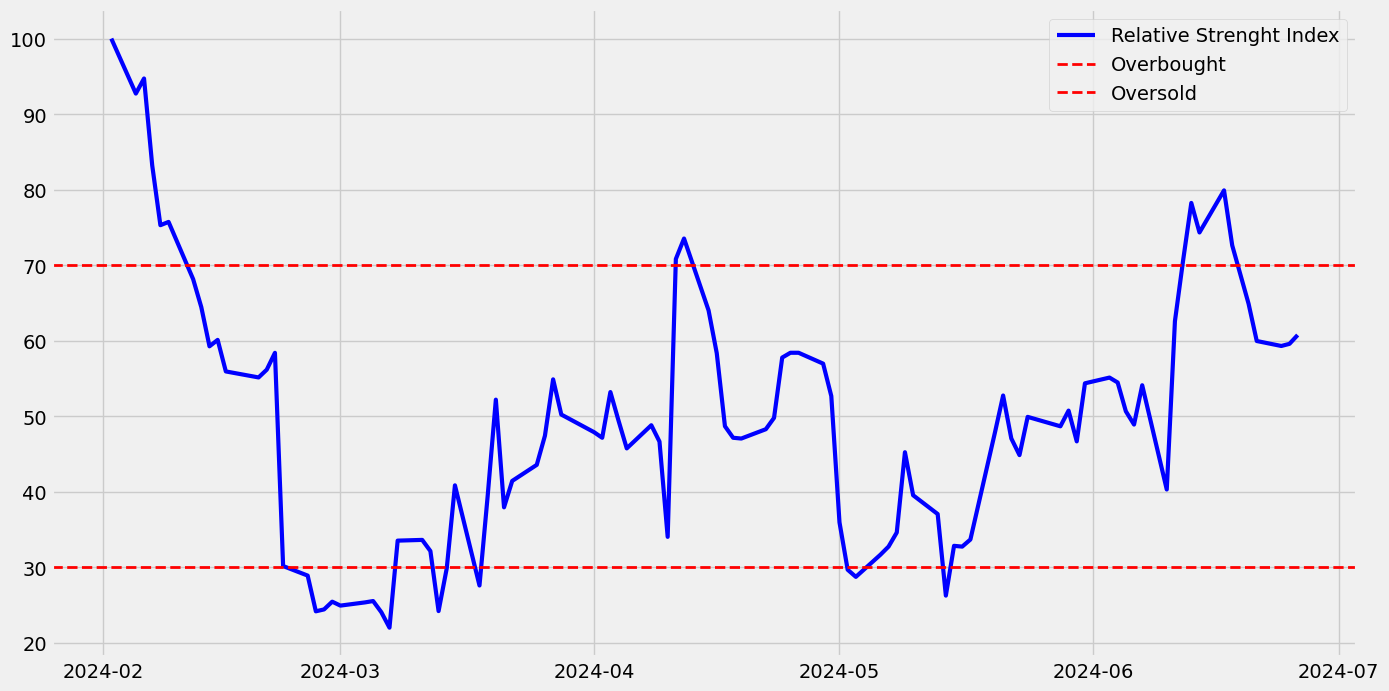

In [125]:
diff = df['4. close'] - df['1. open']

gain = diff.apply(lambda x: x if x > 0 else 0)
loss = diff.apply(lambda x: x if x < 0 else 0)
loss = abs(loss)

avg_gain = gain.rolling(window = 14, min_periods = 1).mean()
avg_loss = loss.rolling(window = 14, min_periods = 1).mean()

rs = avg_gain / avg_loss

rsi = 100 - (100 / (1 + rs))

plt.figure(figsize = (15, 8))
plt.plot(df['timestamp'], rsi, '-', linewidth = 3, label = 'Relative Strenght Index', color = 'blue')
plt.axhline(y = 70, linestyle = '--', color = 'red', linewidth = 2, label = 'Overbought')
plt.axhline(y = 30, linestyle = '--', color = 'red', linewidth = 2, label = 'Oversold')
plt.legend()
plt.grid(True)
plt.show()

In [126]:
df.head()

,timestamp,1. open,2. high,3. low,4. close,5. volume,9. daily change,6. sma,7. ema,8. vwap
99,2024-02-02,179.860,187.330,179.2500,185.85,102551680.0,NaN,185.850,185.850000,185.850000
98,2024-02-05,188.150,189.250,185.8400,187.68,69668820.0,0.009847,186.765,186.078750,186.590295
97,2024-02-06,186.860,189.310,186.7695,189.30,43490759.0,0.008632,187.610,186.481406,187.136614
96,2024-02-07,190.640,191.050,188.6100,189.41,53438955.0,0.000581,188.060,186.847480,187.587988
95,2024-02-08,189.385,189.535,187.3500,188.32,40962046.0,-0.005755,188.112,187.031545,187.684678


<Axes: >

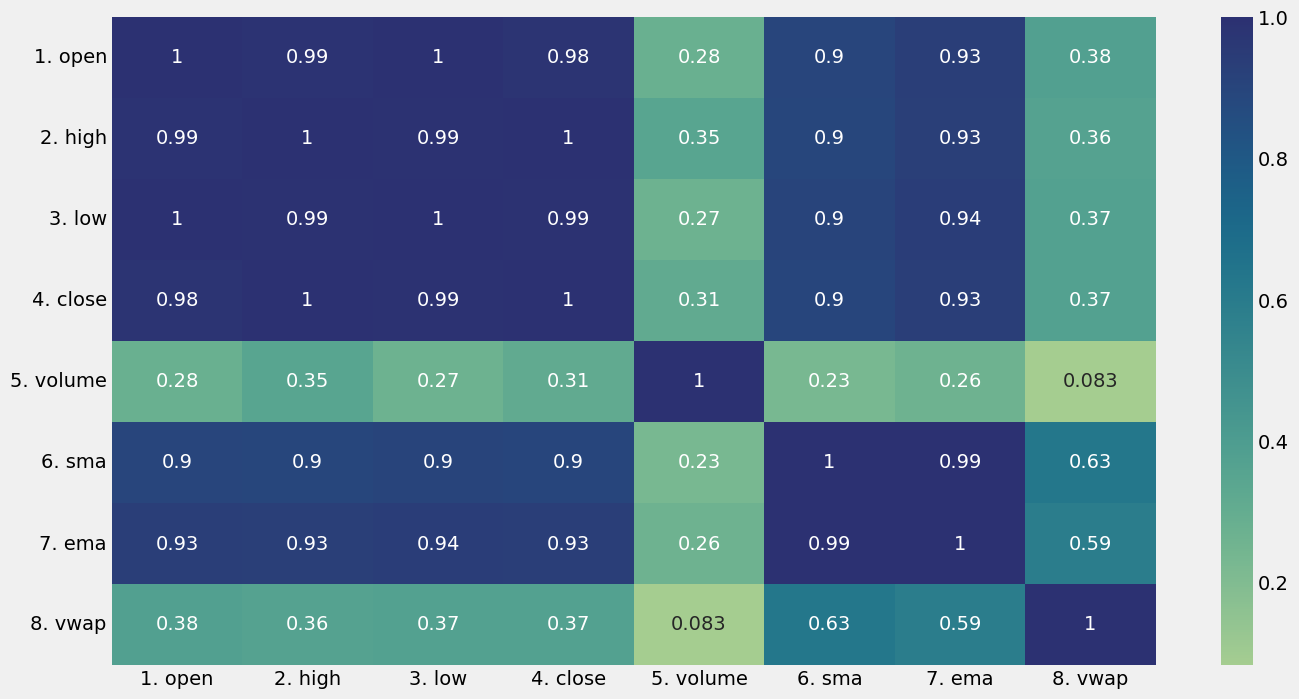

In [127]:
correlation_matrix = df[['1. open', '2. high', '3. low', '4. close', '5. volume', '6. sma', '7. ema', '8. vwap']].corr()

plt.figure(figsize = (15, 8))
sns.heatmap(correlation_matrix, annot = True, cmap = 'crest')

In [128]:
df_pred = df.drop(['9. daily change'], axis = 1).copy()
df_pred.set_index('timestamp', inplace=True)
df_pred

,1. open,2. high,3. low,4. close,5. volume,6. sma,7. ema,8. vwap
timestamp,,,,,,,,
2024-02-02,179.860,187.330,179.2500,185.85,102551680.0,185.850000,185.850000,185.850000
2024-02-05,188.150,189.250,185.8400,187.68,69668820.0,186.765000,186.078750,186.590295
2024-02-06,186.860,189.310,186.7695,189.30,43490759.0,187.610000,186.481406,187.136614
2024-02-07,190.640,191.050,188.6100,189.41,53438955.0,188.060000,186.847480,187.587988
2024-02-08,189.385,189.535,187.3500,188.32,40962046.0,188.112000,187.031545,187.684678
...,...,...,...,...,...,...,...,...
2024-06-20,213.930,214.240,208.8500,209.68,86172451.0,202.658000,204.512463,183.194141
2024-06-21,210.390,211.890,207.1100,207.49,246421353.0,203.738000,204.884655,184.116270
2024-06-24,207.720,212.700,206.5900,208.14,80727006.0,204.797333,205.291573,184.411306


In [129]:
prediction_day = 5
df_pred['Prediction'] = df_pred['4. close'].shift(-prediction_day)
df_pred

,1. open,2. high,3. low,4. close,5. volume,6. sma,7. ema,8. vwap,Prediction
timestamp,,,,,,,,,
2024-02-02,179.860,187.330,179.2500,185.85,102551680.0,185.850000,185.850000,185.850000,188.85
2024-02-05,188.150,189.250,185.8400,187.68,69668820.0,186.765000,186.078750,186.590295,187.15
2024-02-06,186.860,189.310,186.7695,189.30,43490759.0,187.610000,186.481406,187.136614,185.04
2024-02-07,190.640,191.050,188.6100,189.41,53438955.0,188.060000,186.847480,187.587988,184.15
2024-02-08,189.385,189.535,187.3500,188.32,40962046.0,188.112000,187.031545,187.684678,183.86
...,...,...,...,...,...,...,...,...,...
2024-06-20,213.930,214.240,208.8500,209.68,86172451.0,202.658000,204.512463,183.194141,NaN
2024-06-21,210.390,211.890,207.1100,207.49,246421353.0,203.738000,204.884655,184.116270,NaN
2024-06-24,207.720,212.700,206.5900,208.14,80727006.0,204.797333,205.291573,184.411306,NaN


In [130]:
X = np.array(df_pred.drop(['Prediction'], axis = 1))
X = X[:-prediction_day]      # Size upto predict days
print(X.shape)

(95, 8)


In [131]:
y = np.array(df_pred['Prediction'])
y = y[:-prediction_day]      # Size upto predict_days
print(y.shape)

(95,)


In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)      #Splitting the data into 80% for training & 20% for testing
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(76, 8)
(76,)
(19, 8)
(19,)


In [133]:
# Defining the Linear Regression Model

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)      # Training the algorithm

LinearRegression()

In [134]:
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)

Lasso()

In [135]:
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

Ridge()

In [136]:
linear_model_score = linear_model.score(X_test, y_test)
lasso_model_score = lasso_model.score(X_test, y_test)
ridge_model_score = ridge_model.score(X_test, y_test)
print('Linear Model score:', linear_model_score)
print('Lasso Model score:', lasso_model_score)
print('Ridge Model score:', ridge_model_score)

Linear Model score: 0.652030523733717
Lasso Model score: 0.7105097525422202
Ridge Model score: 0.6556911537539079


In [137]:
X_predict = np.array(df_pred.drop(columns=['Prediction']))[-prediction_day:]

linear_model_predict_prediction = linear_model.predict(X_predict)
lasso_model_predict_prediction = lasso_model.predict(X_predict)
ridge_model_predict_prediction = ridge_model.predict(X_predict)

linear_model_real_prediction = linear_model.predict(np.array(df_pred.drop(['Prediction'], 1)))
lasso_model_real_prediction = lasso_model.predict(np.array(df_pred.drop(['Prediction'], 1)))
ridge_model_real_prediction = ridge_model.predict(np.array(df_pred.drop(['Prediction'], 1)))

C:\Users\ZEPHYRUS\AppData\Local\Temp\ipykernel_7668\1524649456.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  linear_model_real_prediction = linear_model.predict(np.array(df_pred.drop(['Prediction'], 1)))
C:\Users\ZEPHYRUS\AppData\Local\Temp\ipykernel_7668\1524649456.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  lasso_model_real_prediction = lasso_model.predict(np.array(df_pred.drop(['Prediction'], 1)))
C:\Users\ZEPHYRUS\AppData\Local\Temp\ipykernel_7668\1524649456.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  ridge_model_real_prediction = ridge_model.predict(np.array(df_pred.drop(['Prediction'], 1)))


In [138]:
predicted_dates = []
recent_date = df_pred.index.max()  # Assuming recent_date is a datetime object


for i in range(prediction_day):
    recent_date += timedelta(days=1)  # Increment recent_date by one day
    predicted_dates.append(recent_date)
     

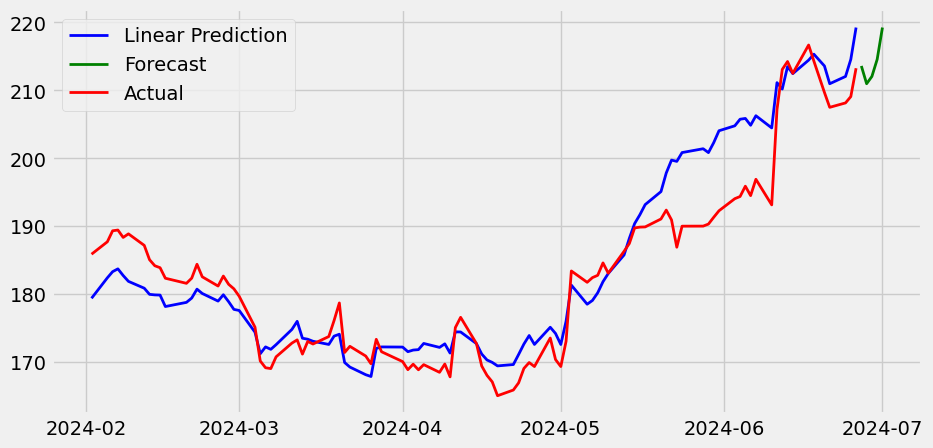

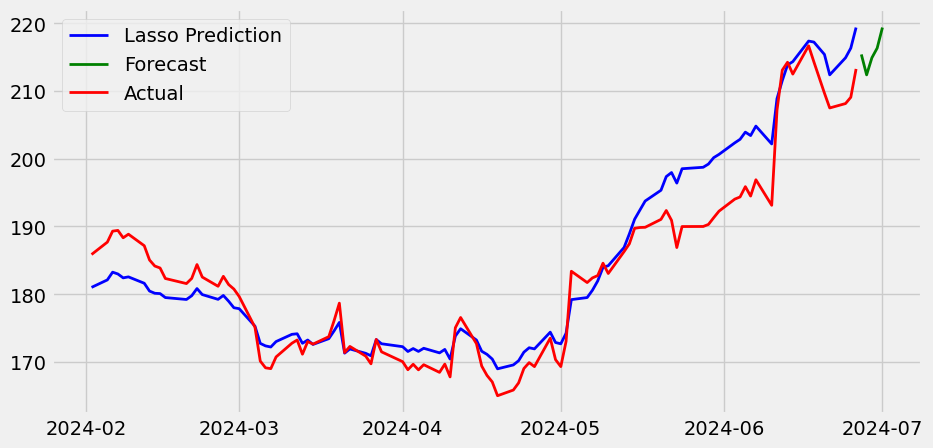

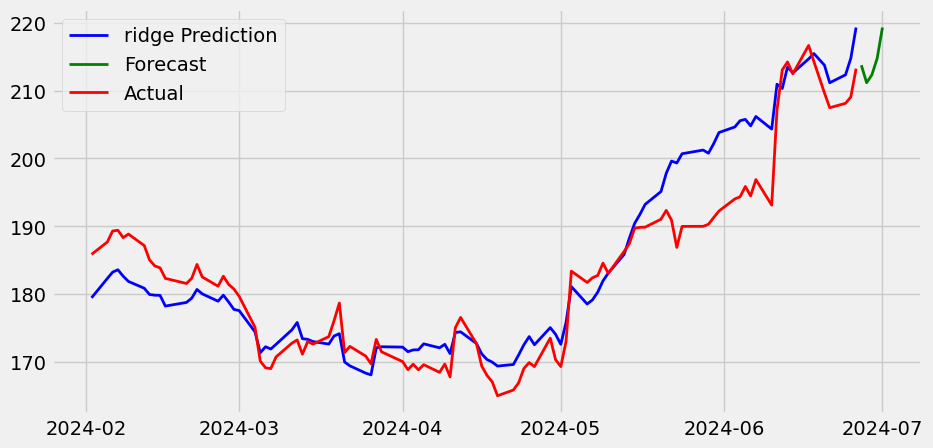

In [139]:
plt.figure(figsize=(10, 5))
plt.plot(df_pred.index, linear_model_real_prediction, label='Linear Prediction', color='blue', linewidth = 2)
plt.plot(predicted_dates, linear_model_predict_prediction, label='Forecast', color='green', linewidth = 2)
plt.plot(df_pred.index, df_pred['4. close'], label='Actual', color='red', linewidth = 2)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df_pred.index, lasso_model_real_prediction, label='Lasso Prediction', color='blue', linewidth = 2)
plt.plot(predicted_dates, lasso_model_predict_prediction, label='Forecast', color='green', linewidth = 2)
plt.plot(df_pred.index, df_pred['4. close'], label='Actual', color='red', linewidth = 2)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df_pred.index, ridge_model_real_prediction, label='ridge Prediction', color='blue', linewidth = 2)
plt.plot(predicted_dates, ridge_model_predict_prediction, label='Forecast', color='green', linewidth = 2)
plt.plot(df_pred.index, df_pred['4. close'], label='Actual', color='red', linewidth = 2)
plt.legend()
plt.grid(True)
plt.show()